In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [34]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=5
c = np.array([25, 25])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [25, 25+l_inner], [25, 25+l_inner+l]])


sub_regions = [[28,4,30,5],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.4/beta, 0.05/beta, 0.05/beta]

In [25]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


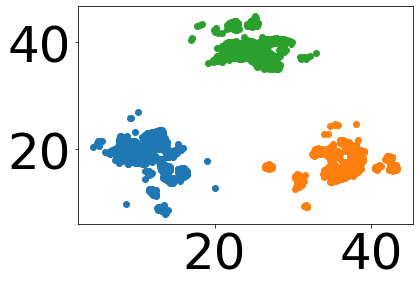

In [26]:
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])

In [172]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.7347328244274809, 0.873015873015873, 0.847877358490566]


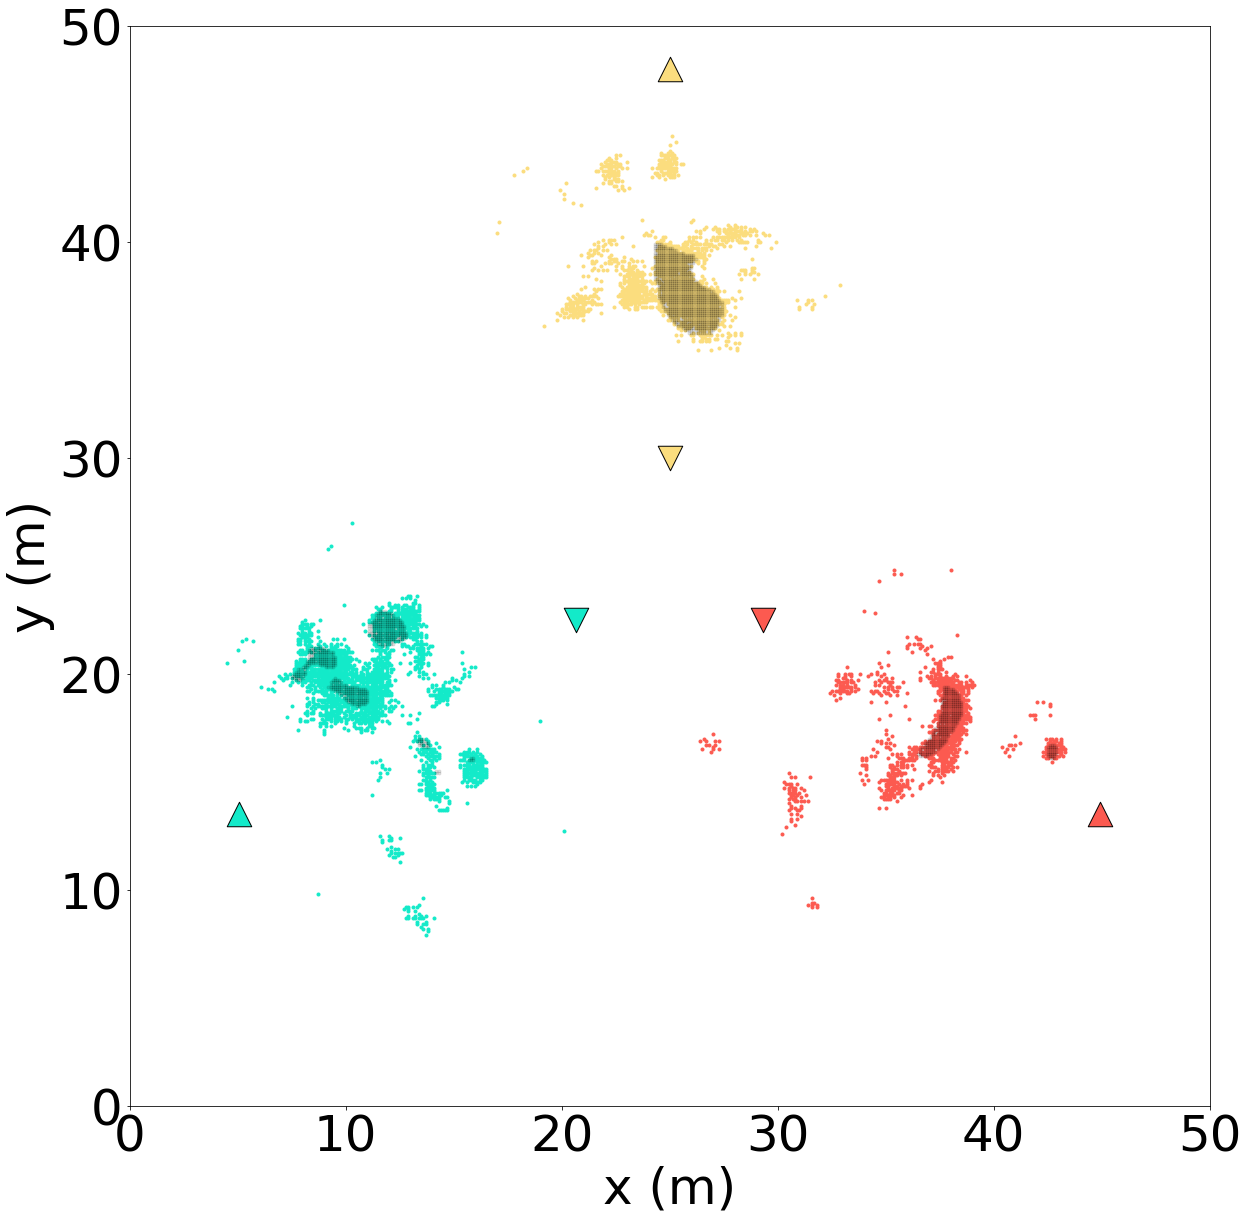

In [173]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [179]:
reload(MRP)
reload(PS)
reload(dtr)
reload(sim)
els = np.array([0.16, 0.02, 0.02])/beta # system traffic is 0.2
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 6 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([14.3 15.4])  ([14.3 15.5])  ([14.2 15.5])  ([14.2 15.4]) Is Interior: False
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
4 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
3 total subregions


In [180]:
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 64.25
Elapsed Time: 0.47


In [181]:
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.51861263 0.48138737]
 [0.96218347 0.         0.03781653]
 [0.95937794 0.04062206 0.        ]]
[2.56 0.32 0.32]
[0.92451782 0.03914601 0.03633617]
[0.49001211 0.26411436 0.24587353]
[21.31909958 20.66124542 22.09690566]
33.68641992062665
34.62020816011244


In [185]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 23039.999999999996
Theoretical Energy Consumption (J): 43286.4
	Th. WT	WT	E (J)	MBS	MBR
AORP	33.69	32.97	43412.71	22929.30	124.75
Tab	---	28.81	43396.10	22932.40	115.45
TSPN	---	34.88	43394.03	22967.20	175.20
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

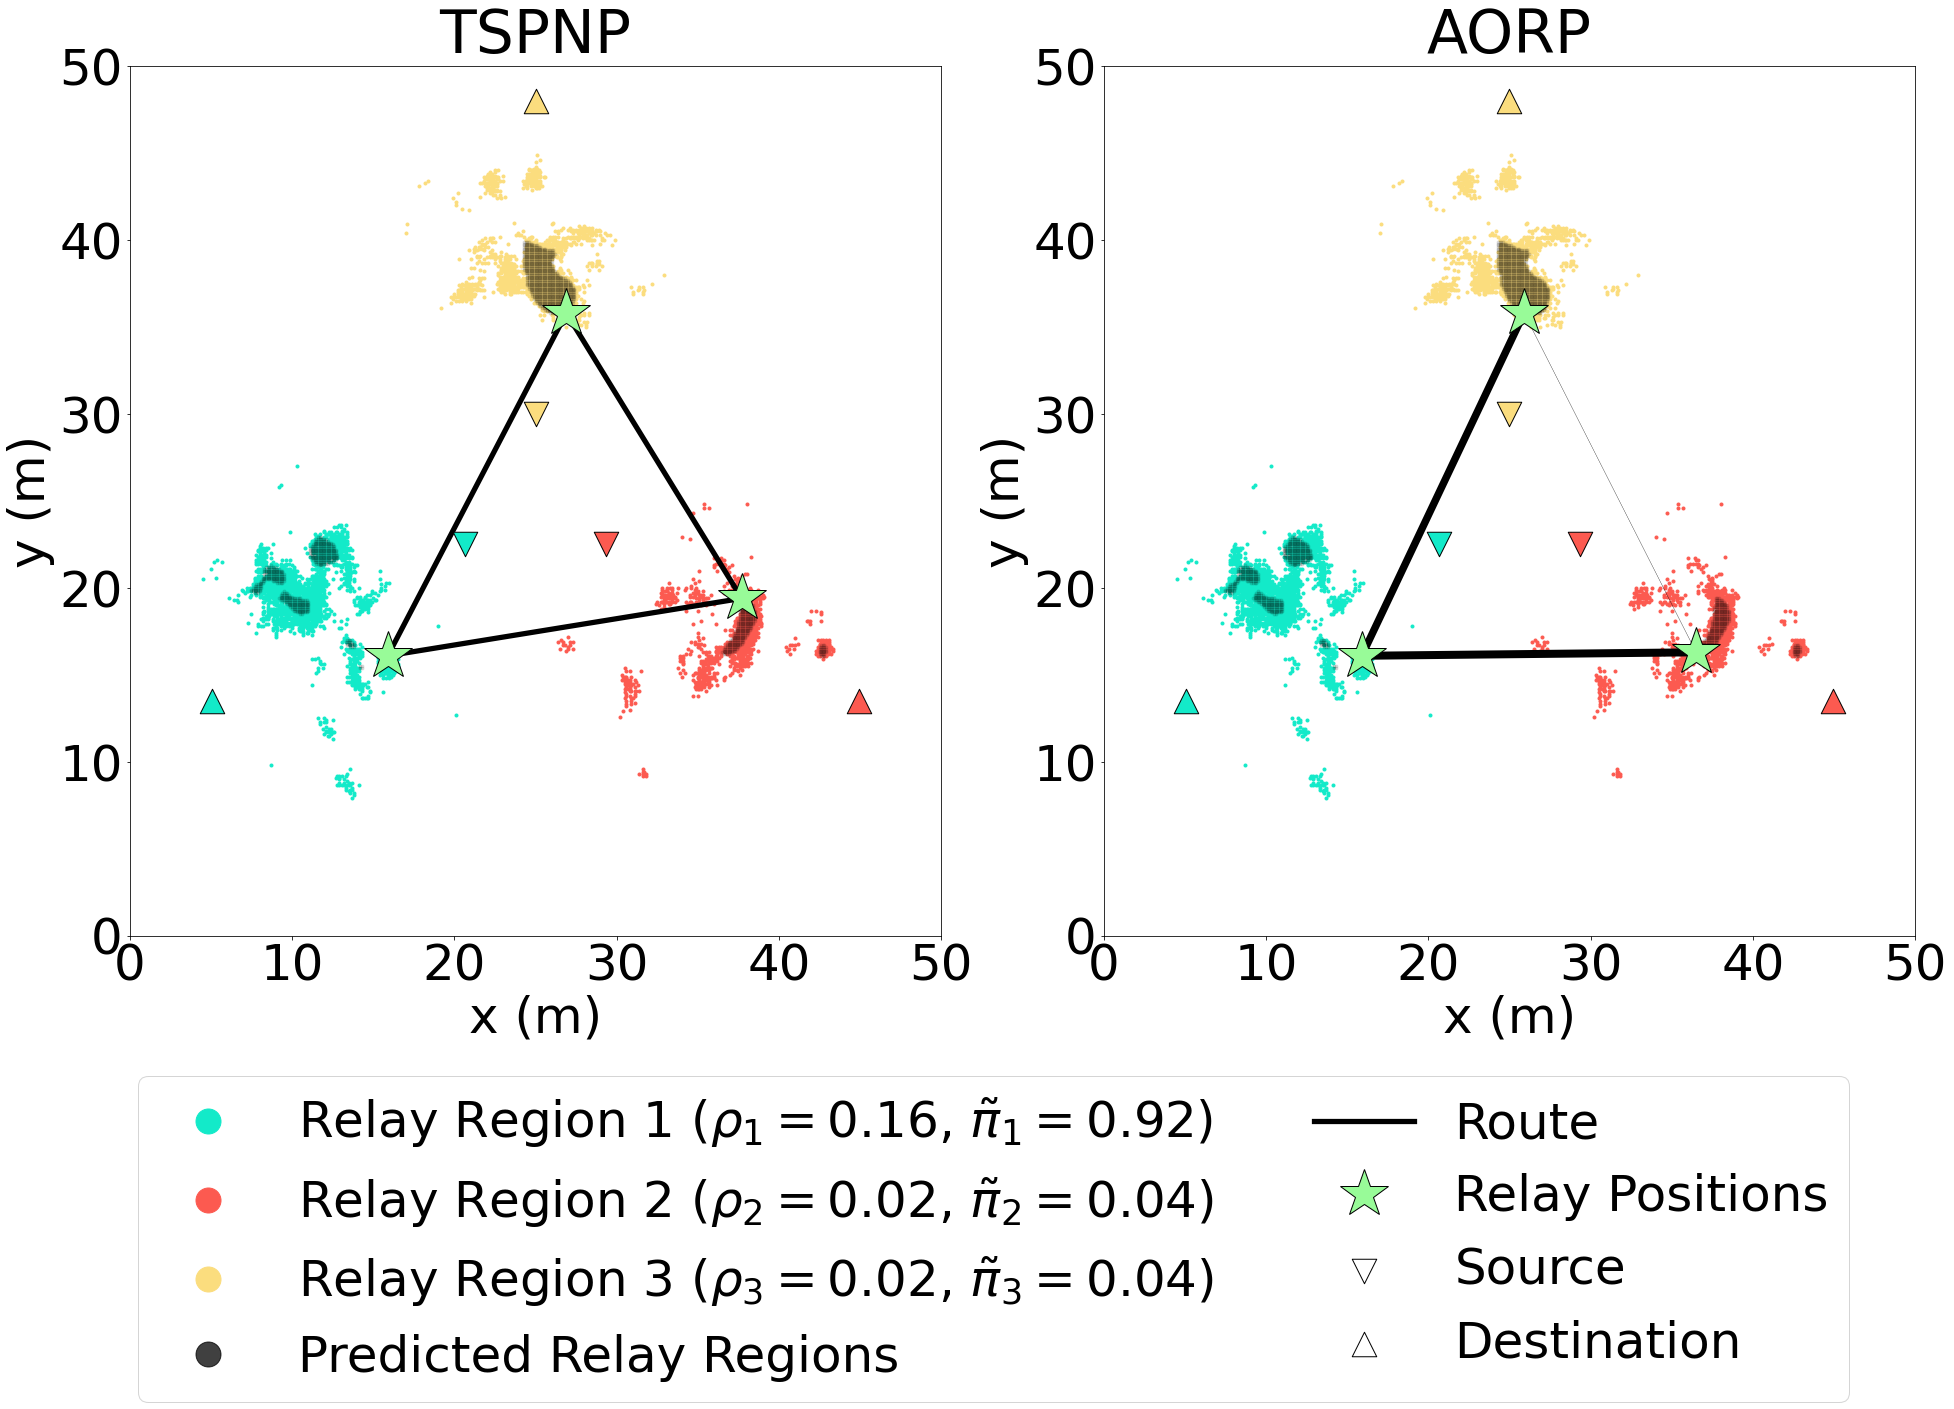

In [187]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, np.array(els)*beta, pi)
plt.savefig("eqi_tri_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("eqi_tri_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

In [69]:
reload(sim)
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}


S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

all_W_aorp = []
all_W_tab = []
all_W_aorp_markovian = []
all_W_tspnp = []
all_s_tilde = []
all_dispersion = []
all_asymmetry = []

all_aorps = []
all_aorp_markvs = []
all_aorpts = []


rho1_percents = np.arange(1/12, 1, 1/12)
print(rho1_percents)
d = len(rho1_percents)

for sys_traffic in [0.2, 0.5, 0.8]:
    W_aorp = []
    W_tab = []
    W_aorp_markovian = []
    W_tspnp = []
    s_tilde = []
    dispersion = []
    asymmetry = []

    aorps = []
    aorp_markvs = []
    aorpts = []
    for prcnt1 in rho1_percents:
        other_prcnt = (1-prcnt1)/2
        val = np.array([prcnt1, other_prcnt, other_prcnt])*sys_traffic/beta
        print(val)
        ps.Ls = val
        print("Finding AORP")
        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        W_aorp.append(AORP['WT'])
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])
        P_tilde, pi_tilde = sim.pi_to_P(pi)
        aorps.append(AORP)

        #also look at truly markovian version
    #     print("Finding Markovian AORP")
    #     AORP_markov = sim.calc_AORP(dt_sys, v, policy_type = 1)
    #     print("Found Markovian AORP")
    #     W_aorp_markovian.append(AORP_markov['WT'])
    #     aorp_markvs.append(AORP_markov)

        #also look at the tabular version
        rtable = SRP.SRPFromPis(pi_tilde, eps=0.01)
        aorpts.append(rtable)
        seconds = 2*60*60
        motion_power = motion.LinearMotionPower(7.2, 0.29, v)
        out, _ = sim.runsimsforpolicy(ps, rtable, S, motion_power, MOBILE_TX_POWER.W, seconds, n_trials = 20)
        #xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
        W_tab.append(out['WT'])
        #S_i = S @ pi

        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        W_tspnp.append(W_cy)


        S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((3,1))
        s_tilde.append(S_obs)

        X = AORP['X']
        X_avg = np.average(X,0, weights=val)
        diffs = X - X_avg
        dists = np.linalg.norm(diffs, axis=1)
        #normalize
        dists /= np.max(dists)
        dispersion.append(np.average(dists, weights=val))

        asymmetry.append(sim.asymmetry(qBase, val*beta))
    
    all_W_aorp.append(W_aorp)
    all_W_tab.append(W_tab)
    all_W_aorp_markovian.append(W_aorp_markovian)
    all_W_tspnp.append(W_tspnp)
    all_s_tilde.append(s_tilde)
    all_dispersion.append(dispersion)
    all_asymmetry.append(asymmetry)

    all_aorps.append(aorps)
    all_aorp_markvs.append(aorp_markvs)
    all_aorpts.append(aorpts)

Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 62.82
Elapsed Time: 0.13
[0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667]
[0.26666667 1.46666667 1.46666667]
Finding AORP
Found AORP
[0.53333333 1.33333333 1.33333333]
Finding AORP
Found AORP
[0.8 1.2 1.2]
Finding AORP
Found AORP
[1.06666667 1.06666667 1.06666667]
Finding AORP
Found AORP
[1.33333333 0.93333333 0.93333333]
Finding AORP
Found AORP
[1.6 0.8 0.8]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[1.86666667 0.66666667 0.66666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[2.13333333 0.53333333 0.53333333]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[2.4 0.4 0.4]
Finding AORP
Found AORP
[2.66666667 0.26666667 0.26666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[2.93333333 0.13333333 0.13333333]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Found AORP
[0.66666667 3.66666667 3.66666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[1.33333333 3.33333333 3.33333333]
Finding AORP
Found AORP
[2. 3. 3.]
Finding AORP
Found AORP
[2.66666667 2.66666667 2.66666667]
Finding AORP
Found AORP
[3.33333333 2.33333333 2.33333333]
Finding AORP
Found AORP
[4. 2. 2.]
Finding AORP
Found AORP
[4.66666667 1.66666667 1.66666667]
Finding AORP
Found AORP
[5.33333333 1.33333333 1.33333333]
Finding AORP
Found AORP
[6. 1. 1.]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[6.66666667 0.66666667 0.66666667]
Finding AORP
Found AORP
[7.33333333 0.33333333 0.33333333]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[1.06666667 5.86666667 5.86666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[2.13333333 5.33333333 5.33333333]
Finding AORP
Found AORP
[3.2 4.8 4.8]
Finding AORP
Found AORP
[4.26666667 4.26666667 4.26666667]
Finding AORP
Found AORP
[5.33333333 3.73333333 3.73333333]
Finding AORP
Found AORP
[6.4 3.2 3.2]
Finding AORP
Found AORP
[7.46666667 2.66666667 2.66666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[8.53333333 2.13333333 2.13333333]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[9.6 1.6 1.6]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[10.66666667  1.06666667  1.06666667]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[11.73333333  0.53333333  0.53333333]
Finding AORP
Found AORP


In [50]:
# for i in range(len(scales)):
#     print(scales[i])
#     print(aorps[i])
#     print(aorp_markvs[i])
#     print(aorpts[i].seq[:30])


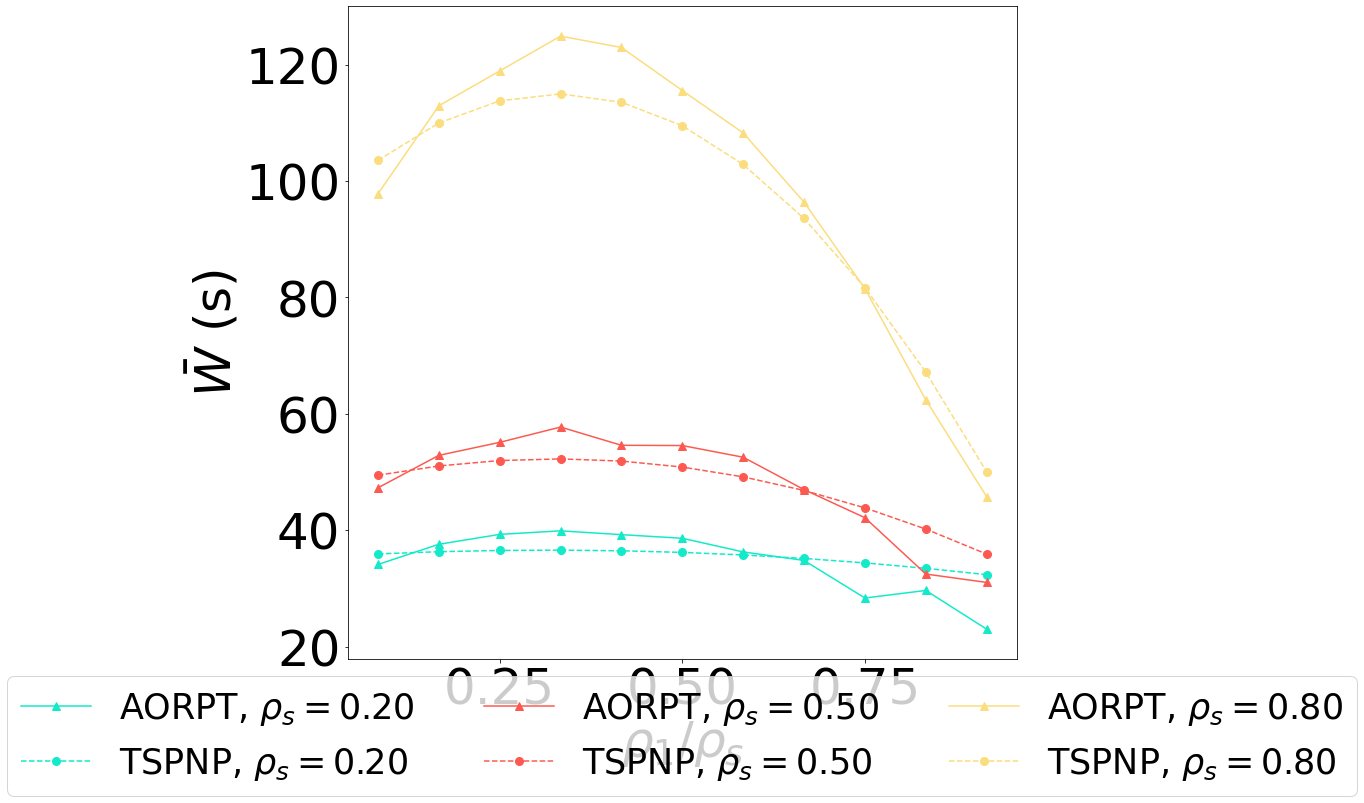

In [99]:
# fig = plt.figure(figsize=(12,12))
# plt.plot(scales, dispersion)
# plt.xlabel("$\\lambda_1$ Scale Factor")
# plt.ylabel("Average Dispersion (s)")
# plt.show()

# dispersion = np.array(dispersion)
# conc = 1-dispersion
# order = np.argsort(conc).tolist()

# fig = plt.figure(figsize=(12,12))
# W_aorp = np.array(W_aorp)
# plt.plot(conc[order], W_aorp[order], label="AORP")
# W_tab = np.array(W_tab)
# plt.plot(conc[order], W_tab[order],  label="AORPT")
# W_tspnp = np.array(W_tspnp)
# plt.plot(conc[order], W_tspnp[order], label="TSPNP")
# plt.xlabel("Relative Concentration (m)")
# plt.ylabel("Waiting Time (s)")
# plt.legend()
# plt.show()

# asymmetry = np.array(asymmetry)
# order = np.argsort(asymmetry).tolist()

# fig = plt.figure(figsize=(12,12))
# W_aorp = np.array(W_aorp)
# plt.plot(asymmetry[order], W_aorp[order], label="AORP")
# W_tab = np.array(W_tab)
# plt.plot(asymmetry[order], W_tab[order],  label="AORPT")
# W_tspnp = np.array(W_tspnp)
# plt.plot(asymmetry[order], W_tspnp[order], label="TSPNP")
# plt.xlabel("Relative Concentration (m)")
# plt.ylabel("Waiting Time (s)")
# plt.legend()
# plt.show()
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 50})
fig = plt.figure(figsize=(12,12))
sys_rs = [0.2, 0.5, 0.8]
for i in range(3):
    W_tab = all_W_tab[i]
    W_tspnp = all_W_tspnp[i]
    #plt.plot(scales/(scales+n-1), W_aorp, '-s', label="AORP")
    # plt.plot(scales, W_aorp_markovian, '-*', label="AORP Markov.")
    plt.plot(rho1_percents, W_tab, '-^', markersize = 8, label="AORPT, $\\rho_s = %.2f$"%(sys_rs[i]), c = sim.COLORS[i])
    plt.plot(rho1_percents, W_tspnp, '--o', markersize = 8, label="TSPNP, $\\rho_s = %.2f$"%(sys_rs[i]), c = sim.COLORS[i])
    # plt.xlabel("$\\rho_1$ Percent of Total Traffic")
    plt.xlabel("$\\rho_1/\\rho_s$")
    plt.ylabel("$\\bar{W}$ (s)")
    
# plt.legend(fontsize= 35, loc='upper left', bbox_to_anchor=[1,1])
plt.legend(fontsize= 35, loc='upper center', bbox_to_anchor=[0.5,0], ncol = 3)
# plt.savefig("eq_tri_w_v_scale.png", format='png', bbox_inches='tight')
# plt.savefig("eq_tri_w_v_scale.eps", format='eps', bbox_inches='tight')
plt.show()

In [105]:

np.savez("eq_tri_plcy_comp_trfc_asym_data",rho1_percents, sys_rs, all_W_tab, all_W_tspnp)

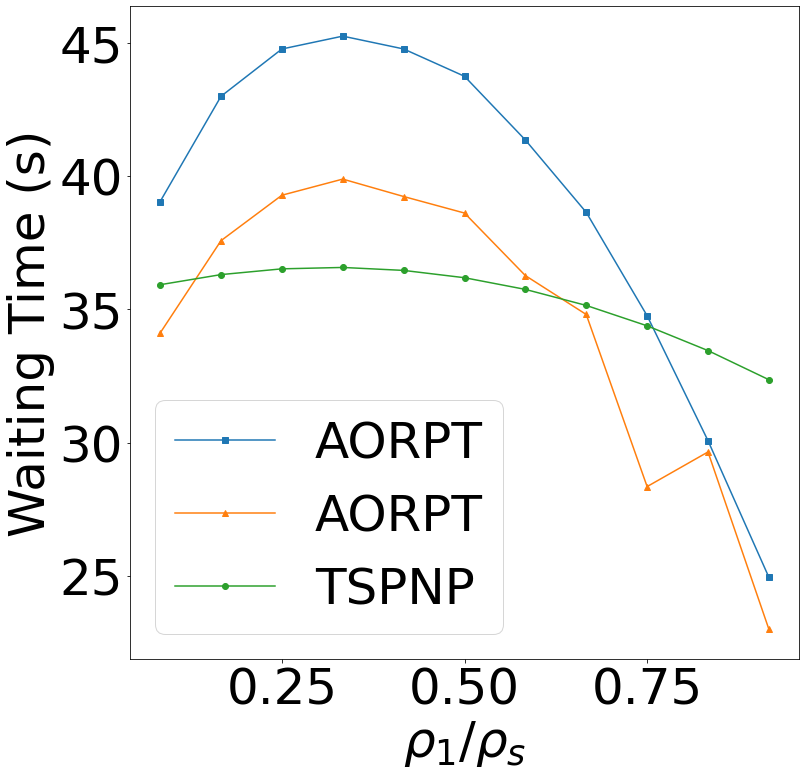

[34.11215718911829, 37.57869919390295, 39.284188559023875, 39.88983036834826, 39.23612857635275, 38.61528505469929, 36.26793226597564, 34.807580232034894, 28.34883113205413, 29.64779501960954, 22.997664139849213]
[35.925381256123515, 36.30505708193358, 36.52114382741962, 36.57364149258163, 36.46255007741962, 36.18786958193358, 35.749600006123515, 35.14774134998943, 34.38229361353132, 33.45325679674917, 32.36063089964301]


In [79]:
# fig = plt.figure(figsize=(12,12))
# plt.plot(scales, dispersion)
# plt.xlabel("$\\lambda_1$ Scale Factor")
# plt.ylabel("Average Dispersion (s)")
# plt.show()

# dispersion = np.array(dispersion)
# conc = 1-dispersion
# order = np.argsort(conc).tolist()

# fig = plt.figure(figsize=(12,12))
# W_aorp = np.array(W_aorp)
# plt.plot(conc[order], W_aorp[order], label="AORP")
# W_tab = np.array(W_tab)
# plt.plot(conc[order], W_tab[order],  label="AORPT")
# W_tspnp = np.array(W_tspnp)
# plt.plot(conc[order], W_tspnp[order], label="TSPNP")
# plt.xlabel("Relative Concentration (m)")
# plt.ylabel("Waiting Time (s)")
# plt.legend()
# plt.show()

# asymmetry = np.array(asymmetry)
# order = np.argsort(asymmetry).tolist()

# fig = plt.figure(figsize=(12,12))
# W_aorp = np.array(W_aorp)
# plt.plot(asymmetry[order], W_aorp[order], label="AORP")
# W_tab = np.array(W_tab)
# plt.plot(asymmetry[order], W_tab[order],  label="AORPT")
# W_tspnp = np.array(W_tspnp)
# plt.plot(asymmetry[order], W_tspnp[order], label="TSPNP")
# plt.xlabel("Relative Concentration (m)")
# plt.ylabel("Waiting Time (s)")
# plt.legend()
# plt.show()
idx = 0
fig = plt.figure(figsize=(12,12))
plt.plot(rho1_percents, all_W_aorp[idx], '-s', label="AORPT")
# plt.plot(scales, W_aorp_markovian, '-*', label="AORP Markov.")
plt.plot(rho1_percents, all_W_tab[idx], '-^', label="AORPT")
plt.plot(rho1_percents, all_W_tspnp[idx], '-o', label="TSPNP")
# plt.xlabel("$\\rho_1$ Percent of Total Traffic")
plt.xlabel("$\\rho_1/\\rho_s$")
plt.ylabel("Waiting Time (s)")
plt.legend()
# plt.savefig("eq_tri_w_v_scale.png", format='png', bbox_inches='tight')
# plt.savefig("eq_tri_w_v_scale.eps", format='eps', bbox_inches='tight')
plt.show()

print(all_W_tab[idx])
print(all_W_tspnp[idx])

In [123]:
#now compare TSPNP, AORP, AORPT while varying offset
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
allos_W_aorp = []
allos_W_tab = []
allos_W_aorp_markovian = []
allos_W_tspnp = []
allos_s_tilde = []
allos_dispersion = []
allos_asymmetry = []

allos_aorps = []
allos_aorp_markvs = []
allos_aorpts = []
n_steps = 9
l = np.reshape(np.array([0, 25, 50, 75, 100, 125, 150, 175, 200]),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T
ps = dt_sys.ps
sys_ts = [0.2, 0.5, 0.8]
for sys_t in sys_ts:
    W_aorp = []
    W_aorp_markovian = []
    W_tab = []
    W_tspnp = []
    s_tilde = []
    dispersion = []

    els = np.array([1/3, 1/3, 1/3])*sys_t/beta
    ps.Ls =els

    for offset, tregion in zip(offsets, regions):
        dt_sys.shiftRegion(0, offset)
        dt_sys.region = tregion
        tjcps[0] += offset
        pjcps[0] += offset
        qBase[0] += offset
        qBase[1] += offset

        #find the TSPNP
        sys_regions = dt_sys.cregions
        tspn_min, tspn_argmin = TSPN.TSPN_BF(sys_regions)
        TSPNP={'X':tspn_argmin[0], 'SEQ':tspn_argmin[1]}
        S_cy = dtr.XtoS(TSPNP['X'])
        S_cyv = np.zeros(n)
        seq = TSPNP['SEQ']
        for i in range(n):
            S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])

         #also look at truly markovian version
    #     print("Finding Markovian AORP")
    #     AORP_markov = sim.calc_AORP(dt_sys, v, policy_type = 1)
    #     print("Found Markovian AORP")
    #     W_aorp_markovian.append(AORP_markov['WT'])

        #also look at the tabular version
        rtable = SRP.SRPFromPis(pi, eps=0.01)
        seconds = 2*60*60
        xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
        print(wt[-1][1])
        W_tab.append(wt[-1][1])
        #S_i = S @ pi
        W_rnd = ps._calc_avg_wait_random(S, pi)
        W_aorp.append(W_rnd)
        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        W_tspnp.append(W_cy)

        P_tilde, pi_tilde = sim.pi_to_P(pi)
        S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((3,1))
        s_tilde.append(S_obs)

        X = AORP['X']
        X_avg = np.average(X,0, weights=els)
        diffs = X - X_avg
        dists = np.linalg.norm(diffs, axis=1)
        #normalize - is this the best way to go?
        dists /= np.max(dists)
        dispersion.append(np.average(dists, weights=val))

        dt_sys.shiftRegion(0, -offset)#move back
        tjcps[0] -= offset
        pjcps[0] -= offset
        qBase[0] -= offset
        qBase[1] -= offset
        
    allos_W_aorp.append(W_aorp)
    allos_W_tab.append(W_tab)
    allos_W_aorp_markovian.append(W_aorp_markovian)
    allos_W_tspnp.append(W_tspnp)
    allos_s_tilde.append(s_tilde)
    allos_dispersion.append(dispersion)
    allos_asymmetry.append(asymmetry)

    allos_aorps.append(aorps)
    allos_aorp_markvs.append(aorp_markvs)
    allos_aorpts.append(aorpts)
    


Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 41.79
Elapsed Time: 0.13
Found AORP
22.239418515592714
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
9 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 62.82
Elapsed Time: 0.12
Found AORP
39.44942968111628
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
130.25119712900826
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 206.37
Elapsed Time: 0.10


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
170.4681172133181
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 256.01
Elapsed Time: 0.11
Found AORP
206.8796345950863
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 305.78
Elapsed Time: 0.10
Found AORP
236.97876042404215
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
256.0037930658863
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 206.37
Elapsed Time: 0.10


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
328.72706461488457
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 256.01
Elapsed Time: 0.11


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
388.1777767488391
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 305.78
Elapsed Time: 0.10
Found AORP
442.9805777605074
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 355.61
Elapsed Time: 0.10
Found AORP
488.37645724848267
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
497.233371326904
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
11 total subregions


In [97]:
##In Case of error during previous cell - maybe put in try-catch
# dt_sys.shiftRegion(0, -offset)#move back
# tjcps[0] -= offset
# pjcps[0] -= offset
# qBase[0] -= offset
# qBase[1] -= offset

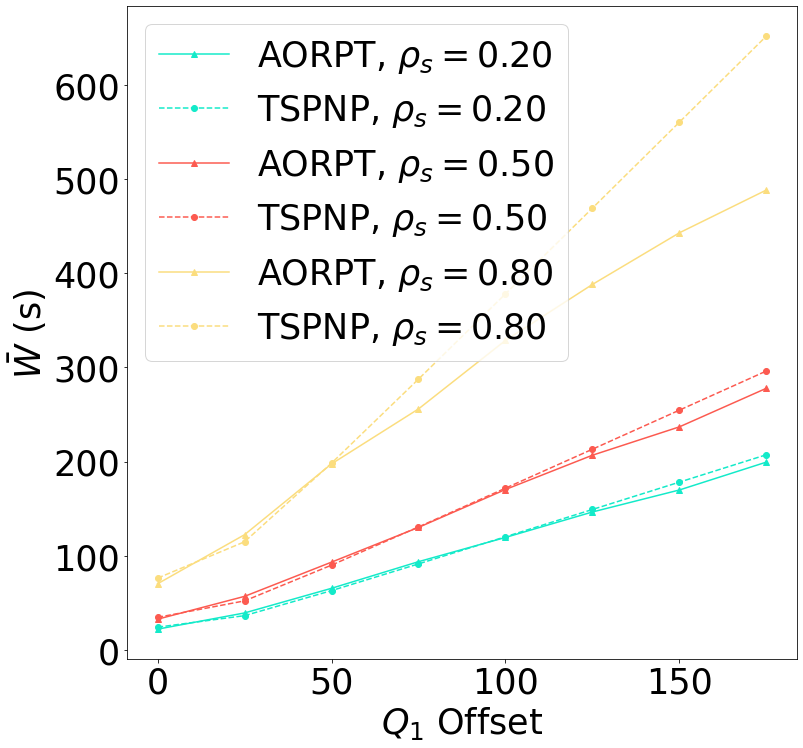

In [125]:
# fig = plt.figure(figsize=(12,12))
# plt.plot(l, dispersion)
# plt.xlabel("$Q_1$ Offset")
# plt.ylabel("Average Dispersion (s)")
# plt.show()

# dispersion = np.array(dispersion)
# conc = 1-dispersion
# order = np.argsort(conc).tolist()

# fig = plt.figure(figsize=(12,12))
# W_aorp = np.array(W_aorp)
# plt.plot(conc[order], W_aorp[order], label="AORP")
# W_tab = np.array(W_tab)
# plt.plot(conc[order], W_tab[order],  label="AORPT")
# W_tspnp = np.array(W_tspnp)
# plt.plot(conc[order], W_tspnp[order], label="TSPNP")
# plt.xlabel("Relative Concentration (m)")
# plt.ylabel("Waiting Time (s)")
# plt.legend()
# plt.show()
fig = plt.figure(figsize=(12,12))
for i in range(3):
    rho_s = sys_ts[i]

    # plt.plot(l, W_aorp, '-s', label="AORP")
    # plt.plot(l, W_aorp_markovian, '-*', label="AORP Mark")
    plt.plot(l[:-1], allos_W_tab[i][:-1], '-^', c=sim.COLORS[i], label="AORPT, $\\rho_s=%.2f$"%(rho_s))
    plt.plot(l[:-1], allos_W_tspnp[i][:-1], '--o', c=sim.COLORS[i], label="TSPNP, $\\rho_s=%.2f$"%(rho_s))
    plt.xlabel("$Q_1$ Offset")
    plt.ylabel("$\\bar{W}$ (s)")
plt.legend()
# plt.savefig("eq_tri_w_v_offset.png", format='png', bbox_inches='tight')
# plt.savefig("eq_tri_w_v_offset.eps", format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


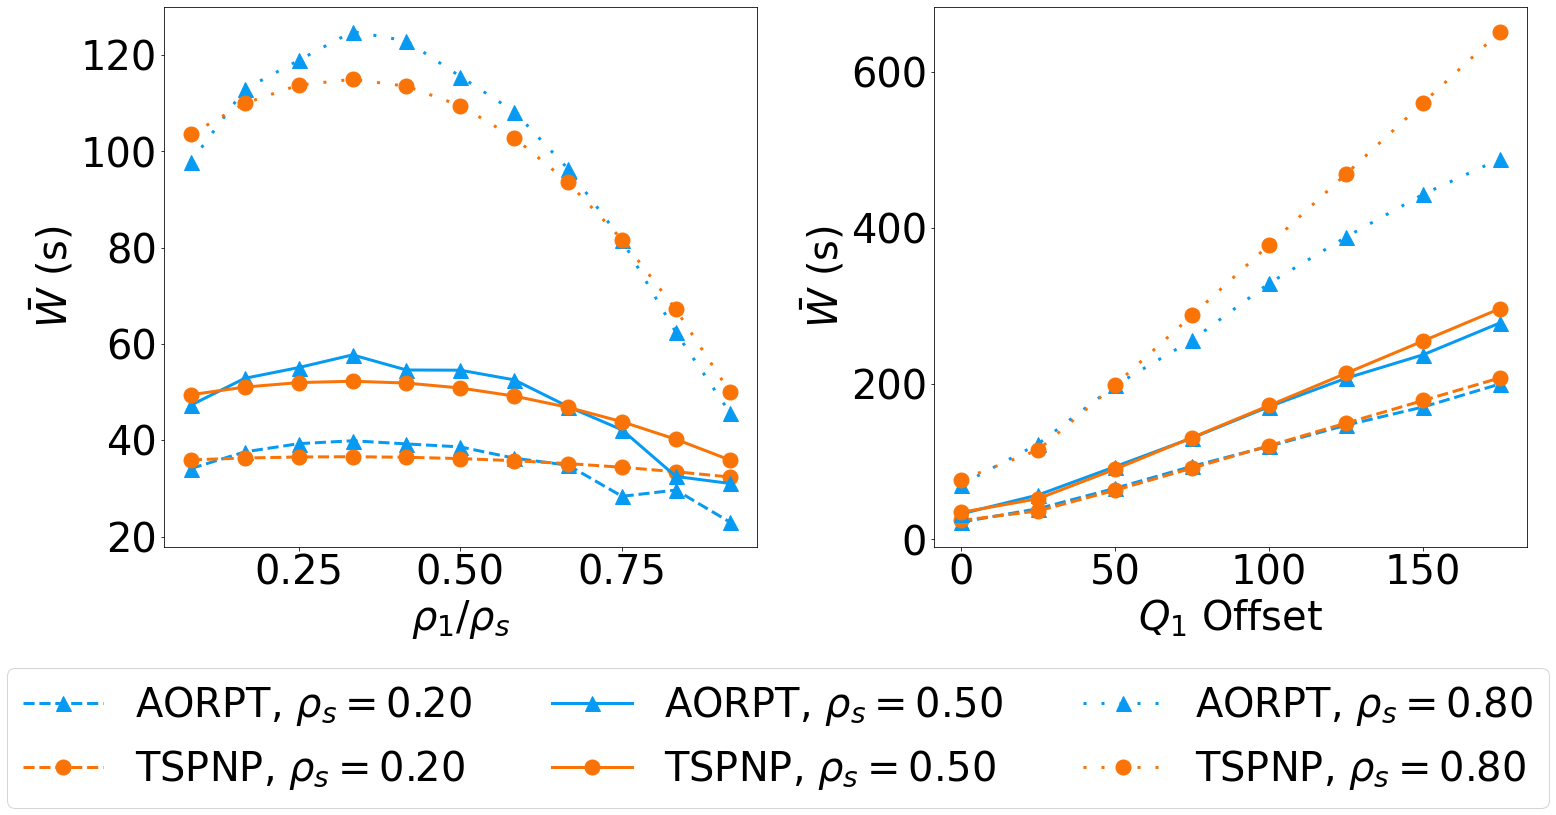

In [201]:
#plot the traffic asymmetry
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 40})
#roll'em into a single figure
figA, (ax1, ax2) = plt.subplots(1,2, figsize=(22, 10))


sys_rs = [0.2, 0.5, 0.8]
styles=["--", "-", (0, (1,5))]
for i in range(3):
    #plt.plot(scales/(scales+n-1), W_aorp, '-s', label="AORP")
    # plt.plot(scales, W_aorp_markovian, '-*', label="AORP Markov.")
    ax1.plot(rho1_percents, all_W_tab[i],  "^", linewidth=3, linestyle=styles[i], markersize=15, label="AORPT, $\\rho_s = %.2f$"%(sys_rs[i]), c = sim.COLORS[5])
    ax1.plot(rho1_percents, all_W_tspnp[i], "o", linewidth=3, linestyle=styles[i], markersize=15, label="TSPNP, $\\rho_s = %.2f$"%(sys_rs[i]), c = sim.COLORS[4])
    # plt.xlabel("$\\rho_1$ Percent of Total Traffic")
    ax1.set_xlabel("$\\rho_1/\\rho_s$")
    ax1.set_ylabel("$\\bar{W}$ (s)")

#plot the offset asymmetry

for i in range(3):
    rho_s = sys_rs[i]
    # plt.plot(l, W_aorp, '-s', label="AORP")
    # plt.plot(l, W_aorp_markovian, '-*', label="AORP Mark")
    ax2.plot(l[:-1], allos_W_tab[i][:-1], "^", linewidth=3, linestyle=styles[i], markersize=15, c=sim.COLORS[5], label="AORPT, $\\rho_s=%.2f$"%(rho_s))
    ax2.plot(l[:-1], allos_W_tspnp[i][:-1], "o", linewidth=3, linestyle=styles[i], markersize=15, c=sim.COLORS[4], label="TSPNP, $\\rho_s=%.2f$"%(rho_s))
    ax2.set_xlabel("$Q_1$ Offset")
    ax2.set_ylabel("$\\bar{W}$ (s)")
    
ax2.set_xticks([0, 50, 100, 150])
handles, labels = ax2.get_legend_handles_labels()
legend = figA.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.05], ncol=3, prop={"size":40})
figA.tight_layout()
# figA
plt.savefig("eq_tri_w_v_offset_and_traffic.png", format='png', bbox_inches='tight')
plt.savefig("eq_tri_w_v_offset_and_traffic.eps", format='eps', bbox_inches='tight')

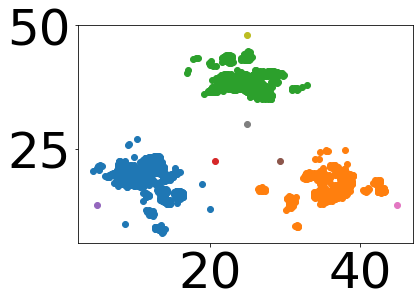

In [160]:
offset = -1*np.array([ -21.65063509,  -12.5 ])
# dt_sys.shiftRegion(0, -offset)#move back
# tjcps[0] -= offset
# pjcps[0] -= offset
# qBase[0] -= offset
# qBase[1] -= offset
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])
    
for qb in qBase:
    plt.scatter(qb[0], qb[1])

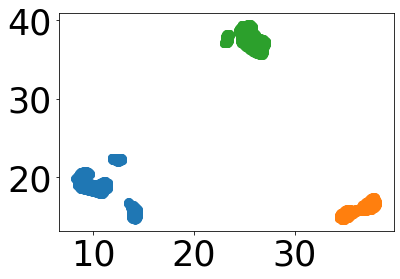

In [117]:
for reg in dt_sys.cregions:
    reg.plot()

[0. 0.] [50.  0. 50.  0.]
1
[-21.65063509 -12.5       ] [ 50.         -21.65063509  50.         -12.5       ]
2
[-43.30127019 -25.        ] [ 50.         -43.30127019  50.         -25.        ]
3
[-64.95190528 -37.5       ] [ 50.         -64.95190528  50.         -37.5       ]
4
[-86.60254038 -50.        ] [ 50.         -86.60254038  50.         -50.        ]
5
[-108.25317547  -62.5       ] [  50.         -108.25317547   50.          -62.5       ]
6
[-129.90381057  -75.        ] [  50.         -129.90381057   50.          -75.        ]
7
[-151.55444566  -87.5       ] [  50.         -151.55444566   50.          -87.5       ]
8
[-173.20508076 -100.        ] [  50.         -173.20508076   50.         -100.        ]
9
